Numbers stored in Farsi network: [0]
Epoch 1, Accuracy: 100.00%


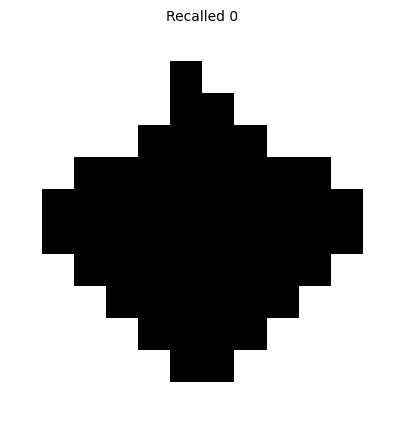

Numbers stored in Farsi network: [0, 1]
Epoch 2, Accuracy: 100.00%


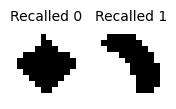

Numbers stored in Farsi network: [0, 1, 2]
Epoch 3, Accuracy: 100.00%


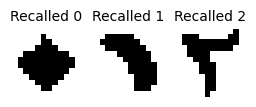

Numbers stored in Farsi network: [0, 1, 2, 3]
Epoch 4, Accuracy: 50.00%


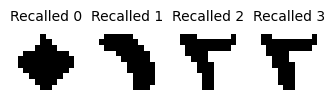

Numbers stored in Farsi network: [0, 1, 2, 3, 4]
Epoch 5, Accuracy: 0.00%


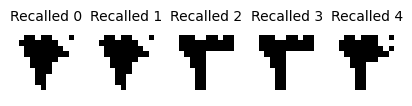

Numbers stored in Farsi network: [0, 1, 2, 3, 4, 5]
Epoch 6, Accuracy: 16.67%


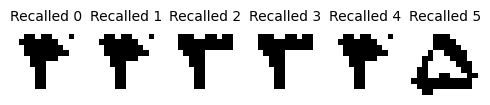

Numbers stored in Farsi network: [0, 1, 2, 3, 4, 5, 6]
Epoch 7, Accuracy: 14.29%


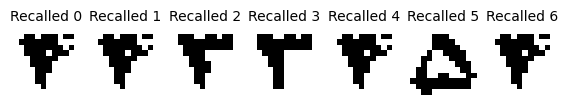

Numbers stored in Farsi network: [0, 1, 2, 3, 4, 5, 6, 7]
Epoch 8, Accuracy: 12.50%


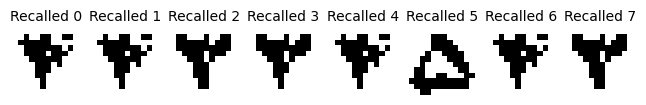

Numbers stored in Farsi network: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Epoch 9, Accuracy: 0.00%


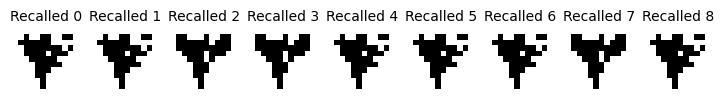

Numbers stored in Farsi network: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch 10, Accuracy: 0.00%


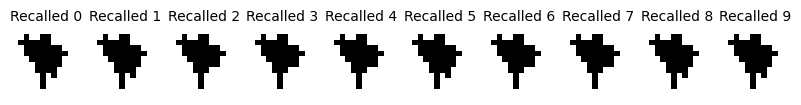

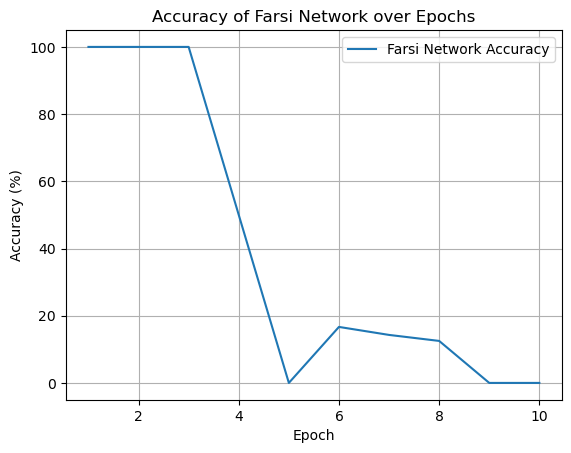

Numbers stored in English network: [0]
Epoch 1, Accuracy: 100.00%


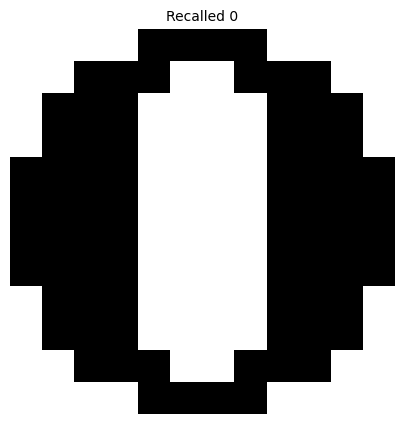

Numbers stored in English network: [0, 1]
Epoch 2, Accuracy: 100.00%


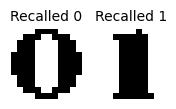

Numbers stored in English network: [0, 1, 2]
Epoch 3, Accuracy: 100.00%


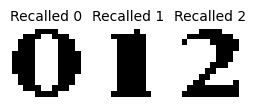

Numbers stored in English network: [0, 1, 2, 3]
Epoch 4, Accuracy: 75.00%


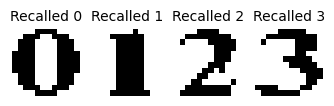

Numbers stored in English network: [0, 1, 2, 3, 4]
Epoch 5, Accuracy: 60.00%


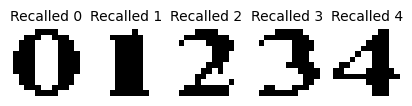

Numbers stored in English network: [0, 1, 2, 3, 4, 5]
Epoch 6, Accuracy: 50.00%


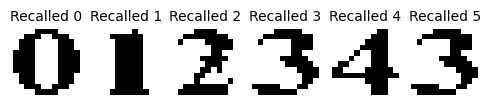

Numbers stored in English network: [0, 1, 2, 3, 4, 5, 6]
Epoch 7, Accuracy: 14.29%


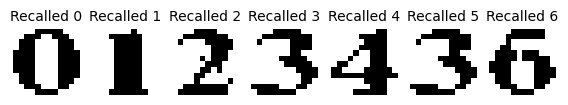

Numbers stored in English network: [0, 1, 2, 3, 4, 5, 6, 7]
Epoch 8, Accuracy: 25.00%


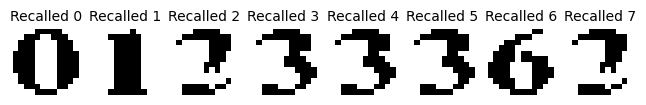

Numbers stored in English network: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Epoch 9, Accuracy: 0.00%


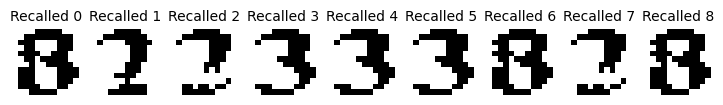

Numbers stored in English network: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Epoch 10, Accuracy: 0.00%


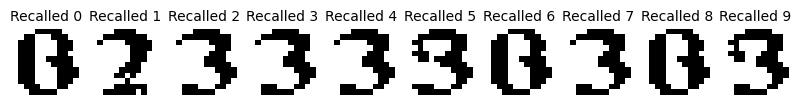

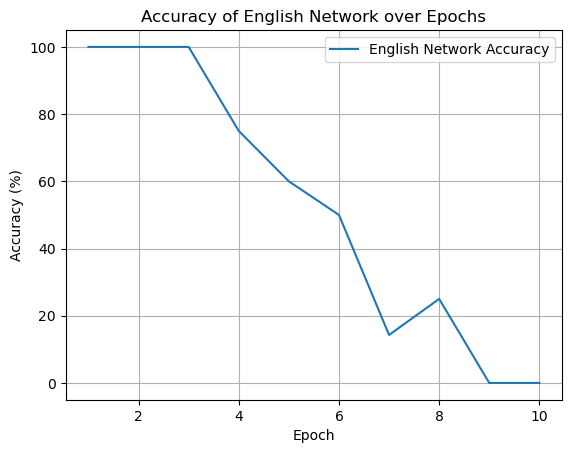

In [28]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def read_and_preprocess_image(image_path, image_size=(12, 12)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)  # Use interpolation for better quality
    # Normalize pixel values
    resized_image = resized_image.astype(np.float32) / 255.0
    _, binary_image = cv2.threshold(resized_image, 0.5, 1, cv2.THRESH_BINARY)
    return binary_image.flatten()


class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, patterns):
        patterns = np.array(patterns)
        self.weights = (patterns.T @ patterns) / self.size
        np.fill_diagonal(self.weights, 0)  # Set diagonal elements to 0

    def calculate_energy(self, pattern, desired_outputs):
        energy = 0
        for d in range(len(desired_outputs)):
            for k in range(self.size):
                energy += abs(desired_outputs[d][k] - pattern[k])
        return energy

    def recall(self, pattern, desired_outputs, strategy='Asynchronous', max_steps=100):
        previous_pattern = np.zeros_like(pattern)
        energy_values = []  # List to store energy at each epoch
        steps = 0

        while not np.array_equal(pattern, previous_pattern) and steps < max_steps:
            previous_pattern = pattern.copy()
            steps += 1
            if strategy == 'Asynchronous':
                for i in range(self.size):
                    net_input = np.dot(self.weights[i], pattern)
                    pattern[i] = 1 if net_input > 0 else -1
            elif strategy == 'Synchronous':
                net_input = np.dot(self.weights, pattern)
                pattern = np.where(net_input > 0, 1, -1)

            energy = self.calculate_energy(pattern, desired_outputs)
            energy_values.append(energy)

        return pattern, energy_values

    def add_noise(self, pattern, noise_level=0.1):
        noise = np.random.normal(0, noise_level, size=pattern.shape)  # Use Gaussian noise
        noisy_pattern = pattern + noise
        return np.where(noisy_pattern > 0.5, 1, -1)

    def convert_images_to_patterns(self, image_paths, image_size):
        patterns = []
        for path in image_paths:
            pattern = read_and_preprocess_image(path, image_size)
            pattern = np.where(pattern == 0, -1, 1)  # Convert 0 to -1 and 1 remains 1
            patterns.append(pattern)
        return patterns

def hamming_distance(vec1, vec2):
  if len(vec1) != len(vec2):
    print("hamming_distance error - The two vectors are of varying lengths.")
    return
  
  n = len(vec1)

  distance = 0
  for i, bit in enumerate(vec1):
    if bit != vec2[i]:
      distance += 1

  return (distance / n)

def apply_noise_and_recall(network, patterns, noise_levels, strategy='Asynchronous'):
    results = []

    for noise_level in noise_levels:
        correct_count_async = 0
        correct_count_sync = 0
        energy_async = []
        energy_sync = []

        for pattern in patterns:
            noisy_pattern = network.add_noise(pattern, noise_level)

            # Asynchronous recall
            recalled_async, energy_async_pattern = network.recall(noisy_pattern, patterns, strategy='Asynchronous')  # Pass patterns as desired_outputs
            energy_async.append(energy_async_pattern)
            if hamming_distance(recalled_async, pattern) == 0:
                correct_count_async += 1

            # Synchronous recall
            recalled_sync, energy_sync_pattern = network.recall(noisy_pattern, patterns, strategy='Synchronous')  # Pass patterns as desired_outputs
            energy_sync.append(energy_sync_pattern)
            if hamming_distance(recalled_sync, pattern) == 0:
                correct_count_sync += 1

        results.append({
            'Noise Level': noise_level,
            'Async Accuracy': correct_count_async / len(patterns) * 100,
            'Sync Accuracy': correct_count_sync / len(patterns) * 100,
            'Async Energy': np.mean([np.mean(e) for e in energy_async]),  # Average energy for async
            'Sync Energy': np.mean([np.mean(e) for e in energy_sync]),  # Average energy for sync
        })

    results_df = pd.DataFrame(results)
    return results_df


def plot_results(farsi_results, english_results):
    plt.figure(figsize=(10, 6))
    plt.plot(farsi_results['Noise Level'], farsi_results['Async Accuracy'], label='Farsi Async', marker='o')
    plt.plot(farsi_results['Noise Level'], farsi_results['Sync Accuracy'], label='Farsi Sync', marker='o')
    plt.plot(english_results['Noise Level'], english_results['Async Accuracy'], label='English Async', marker='o')
    plt.plot(english_results['Noise Level'], english_results['Sync Accuracy'], label='English Sync', marker='o')

    plt.title('Comparison of Retrieval Accuracy with Noise Levels')
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def display_pattern_side_by_side(patterns, titles):
    num_patterns = len(patterns)
    fig, axs = plt.subplots(1, num_patterns, figsize=(num_patterns * 1, 1) if num_patterns > 1 else (5, 5))
    if num_patterns == 1:
        axs = [axs]
    for i, pattern in enumerate(patterns):
        pattern_image = np.where(pattern == -1, 0, 1).reshape(12, 12)
        axs[i].imshow(pattern_image, cmap='gray', interpolation='nearest')
        axs[i].axis('off')
        axs[i].set_title(titles[i], fontsize=10)
    plt.show()

def incremental_trainings(network, patterns, description, strategy='Asynchronous', verbose=True, noise=False):
    accuracies = []  # List to track accuracies
    for i in range(len(patterns)):
        # Train the network with the current pattern
        network.train([patterns[j] for j in range(i + 1)])  
        if verbose:
            print(f"Numbers stored in {description} network: {list(range(i + 1))}") 

        correct_count = 0
        for j in range(i + 1):
            if noise:
                p = network.add_noise(patterns[j].copy())
            else:
                p = patterns[j].copy()
            recalled_pattern, _ = network.recall(p, patterns, strategy=strategy)  # Pass patterns as desired_outputs
            if hamming_distance(recalled_pattern, patterns[j]) == 0:
                correct_count += 1

        accuracy = correct_count / (i + 1) * 100  # Calculate accuracy
        accuracies.append(accuracy)  # Store accuracy

        if verbose:
            print(f"Epoch {i+1}, Accuracy: {accuracy:.2f}%")

        recalled_patterns = []
        titles = []
        for j in range(i + 1):
            if noise:
                p = network.add_noise(patterns[j].copy())
            else:
                p = patterns[j].copy()
            recalled_pattern, _ = network.recall(p, patterns, strategy=strategy)  # Pass patterns as desired_outputs
            recalled_patterns.append(recalled_pattern)
            titles.append(f"Recalled {j}")     

        display_pattern_side_by_side(recalled_patterns, titles)

    # Plot accuracy over epochs
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'{description} Network Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Accuracy of {description} Network over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()


farsi_digits = [f'digits/farsi/{i}.PNG' for i in range(10)]
english_digits = [f'digits/english/{i}.PNG' for i in range(10)]

hopfield_farsi = HopfieldNetwork(size=12 * 12)
hopfield_english = HopfieldNetwork(size=12 * 12)

farsi_patterns = hopfield_farsi.convert_images_to_patterns(farsi_digits, (12, 12))
english_patterns = hopfield_english.convert_images_to_patterns(english_digits, (12, 12))

incremental_trainings(hopfield_farsi, farsi_patterns, "Farsi")
incremental_trainings(hopfield_english, english_patterns, "English")


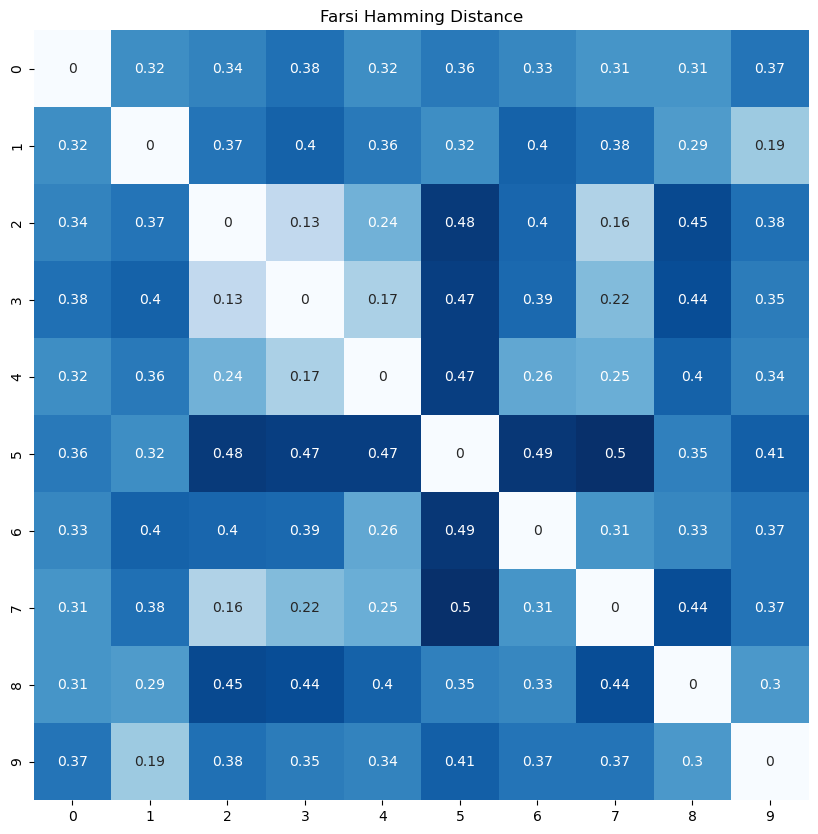

In [30]:
farsi_hamming_matrix = np.zeros((10, 10))  
for i in range(10):
    for j in range(10):
        farsi_hamming_matrix[i, j] = hamming_distance(farsi_patterns[i], farsi_patterns[j])

english_hamming_matrix = np.zeros((10, 10))  
for i in range(10):
    for j in range(10):
        english_hamming_matrix[i, j] = hamming_distance(english_patterns[i], english_patterns[j])    
plt.figure(figsize=(10, 10))
sns.heatmap(farsi_hamming_matrix, annot=True, cmap="Blues", cbar=False)
plt.title("Farsi Hamming Distance")
plt.show()

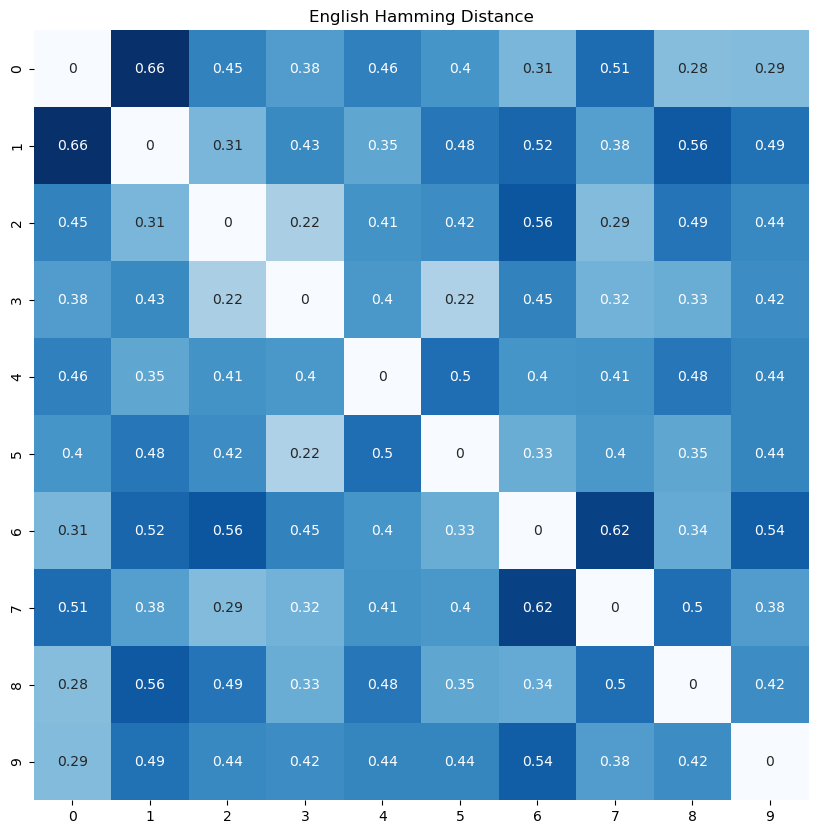

In [31]:
plt.figure(figsize=(10, 10))
sns.heatmap(english_hamming_matrix, annot=True, cmap="Blues", cbar=False)
plt.title("English Hamming Distance")
plt.show()

Farsi Results:
   Noise Level  Async Accuracy  Sync Accuracy  Async Energy  Sync Energy
0          0.1             0.0            0.0    694.826667        680.0
1          0.2             0.0            0.0    694.826667        680.0
2          0.3             0.0            0.0    695.460000        680.0

English Results:
   Noise Level  Async Accuracy  Sync Accuracy  Async Energy  Sync Energy
0          0.1             0.0            0.0    931.173333   904.533333
1          0.2             0.0            0.0    931.173333   904.533333
2          0.3             0.0            0.0    933.453333   904.533333


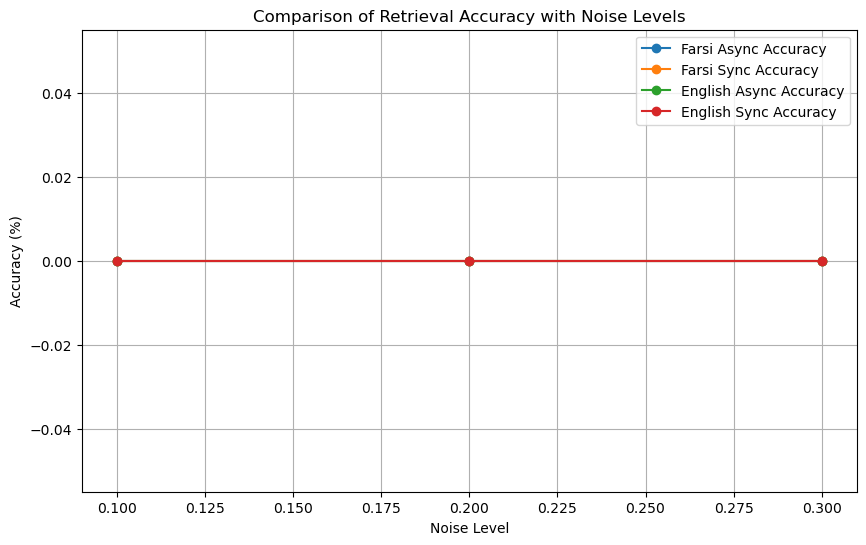

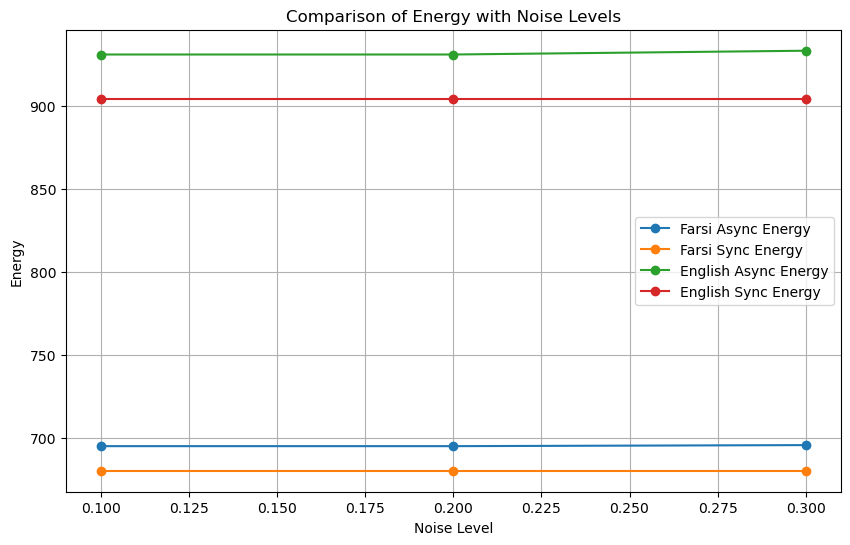

In [33]:

farsi_digits = [f'digits/farsi/{i}.PNG' for i in range(10)]
english_digits = [f'digits/english/{i}.PNG' for i in range(10)]

hopfield_farsi = HopfieldNetwork(size=144) 
hopfield_english = HopfieldNetwork(size=144)

farsi_patterns = hopfield_farsi.convert_images_to_patterns(farsi_digits, (12, 12))
english_patterns = hopfield_english.convert_images_to_patterns(english_digits, (12, 12))

hopfield_farsi.train(farsi_patterns)
hopfield_english.train(english_patterns)

noise_levels = [0.1, 0.2, 0.3]  
farsi_results = apply_noise_and_recall(hopfield_farsi, farsi_patterns, noise_levels)
english_results = apply_noise_and_recall(hopfield_english, english_patterns, noise_levels)

print("Farsi Results:")
print(farsi_results)

print("\nEnglish Results:")
print(english_results)

plt.figure(figsize=(10, 6))
plt.plot(farsi_results['Noise Level'], farsi_results['Async Accuracy'], label='Farsi Async Accuracy', marker='o')
plt.plot(farsi_results['Noise Level'], farsi_results['Sync Accuracy'], label='Farsi Sync Accuracy', marker='o')
plt.plot(english_results['Noise Level'], english_results['Async Accuracy'], label='English Async Accuracy', marker='o')
plt.plot(english_results['Noise Level'], english_results['Sync Accuracy'], label='English Sync Accuracy', marker='o')

plt.title('Comparison of Retrieval Accuracy with Noise Levels')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(farsi_results['Noise Level'], farsi_results['Async Energy'], label='Farsi Async Energy', marker='o')
plt.plot(farsi_results['Noise Level'], farsi_results['Sync Energy'], label='Farsi Sync Energy', marker='o')
plt.plot(english_results['Noise Level'], english_results['Async Energy'], label='English Async Energy', marker='o')
plt.plot(english_results['Noise Level'], english_results['Sync Energy'], label='English Sync Energy', marker='o')

plt.title('Comparison of Energy with Noise Levels')
plt.xlabel('Noise Level')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
image_sizes = [(12, 12), (28, 28), (40, 40)]

farsi_results_all_sizes = {}
english_results_all_sizes = {}

for image_size in image_sizes:
    print(f"Testing with image size: {image_size[0]}x{image_size[1]}")

    hopfield_farsi = HopfieldNetwork(size=image_size[0] * image_size[1])  
    hopfield_english = HopfieldNetwork(size=image_size[0] * image_size[1])

    farsi_patterns = hopfield_farsi.convert_images_to_patterns(farsi_digits, image_size=image_size)
    english_patterns = hopfield_english.convert_images_to_patterns(english_digits, image_size=image_size)

    hopfield_farsi.train(farsi_patterns)
    hopfield_english.train(english_patterns)

    farsi_results = apply_noise_and_recall(hopfield_farsi, farsi_patterns, noise_levels)
    english_results = apply_noise_and_recall(hopfield_english, english_patterns, noise_levels)

    farsi_results_all_sizes[image_size] = farsi_results
    english_results_all_sizes[image_size] = english_results

    print(f"Farsi Results (Image size {image_size[0]}x{image_size[1]}):")
    print(farsi_results)

    print(f"\nEnglish Results (Image size {image_size[0]}x{image_size[1]}):")
    print(english_results)



Testing with image size: 12x12
Farsi Results (Image size 12x12):
   Noise Level  Async Accuracy  Sync Accuracy  Async Energy  Sync Energy
0          0.1             0.0            0.0    694.826667        680.0
1          0.2             0.0            0.0    694.826667        680.0
2          0.3             0.0            0.0    695.593333        680.0

English Results (Image size 12x12):
   Noise Level  Async Accuracy  Sync Accuracy  Async Energy  Sync Energy
0          0.1             0.0            0.0    931.173333   904.533333
1          0.2             0.0            0.0    931.173333   904.533333
2          0.3             0.0            0.0    936.266667   904.533333
Testing with image size: 28x28
Farsi Results (Image size 28x28):
   Noise Level  Async Accuracy  Sync Accuracy  Async Energy  Sync Energy
0          0.1             0.0            0.0   3816.133333       3758.0
1          0.2             0.0            0.0   3816.533333       3758.0
2          0.3             0.0

Farsi Network Capacity Results:
   Num Patterns  Async Accuracy  Sync Accuracy  Async Energy  Sync Energy
0             1      100.000000     100.000000      0.000000     0.000000
1             2      100.000000     100.000000    934.000000   934.000000
2             3      100.000000     100.000000   2109.333333  2109.333333
3             4       25.000000      25.000000   2734.000000  2734.000000
4             5        0.000000       0.000000   3017.288889  2977.600000
5             6       16.666667      16.666667   4734.833333  4696.000000
6             7       14.285714      14.285714   5758.552381  5752.857143
7             8       12.500000      12.500000   6397.911111  6384.500000
8             9        0.000000       0.000000   7123.051852  7040.888889
9            10        0.000000       0.000000   7841.933333  7732.000000

English Network Capacity Results:
   Num Patterns  Async Accuracy  Sync Accuracy  Async Energy   Sync Energy
0             1           100.0          100

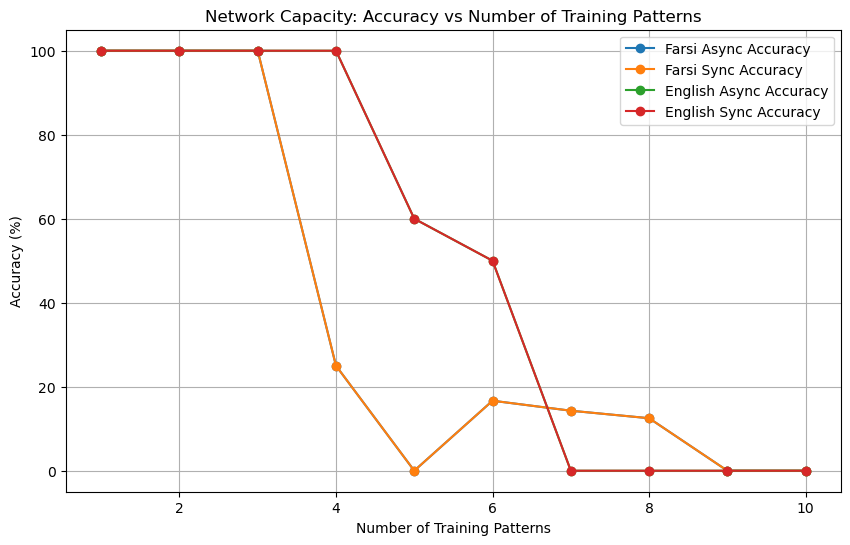

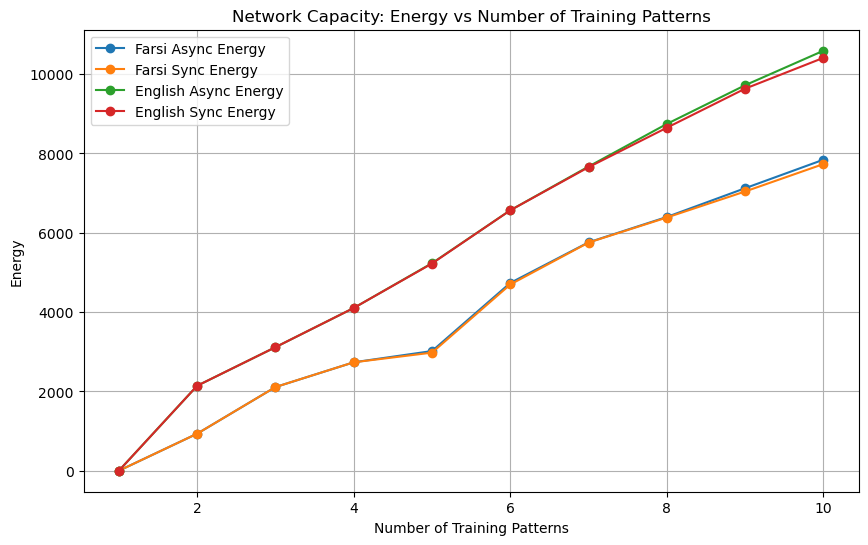


Comparative Analysis of Retrieval Methods:
Farsi - Async Accuracy: 0.0% | Sync Accuracy: 0.0%
Farsi - Async Energy: 7841.006666666665 | Sync Energy: 7732.0
English - Async Accuracy: 0.0% | Sync Accuracy: 0.0%
English - Async Energy: 10571.42037037037 | Sync Energy: 10379.6


In [36]:
def evaluate_network_capacity(network, all_patterns, noise_levels):
    capacity_results = []
    for num_patterns in range(1, len(all_patterns) + 1):
        patterns_to_train = all_patterns[:num_patterns]
        network.train(patterns_to_train) 

        # Apply noise and recall for both Farsi and English digits
        results = apply_noise_and_recall(network, patterns_to_train, noise_levels)

        capacity_results.append({
            'Num Patterns': num_patterns,
            'Async Accuracy': results['Async Accuracy'].mean(),
            'Sync Accuracy': results['Sync Accuracy'].mean(),
            'Async Energy': results['Async Energy'].mean(),
            'Sync Energy': results['Sync Energy'].mean()
        })
    
    capacity_df = pd.DataFrame(capacity_results)
    return capacity_df

farsi_capacity_results = evaluate_network_capacity(hopfield_farsi, farsi_patterns, noise_levels)
english_capacity_results = evaluate_network_capacity(hopfield_english, english_patterns, noise_levels)

print("Farsi Network Capacity Results:")
print(farsi_capacity_results)

print("\nEnglish Network Capacity Results:")
print(english_capacity_results)

plt.figure(figsize=(10, 6))
plt.plot(farsi_capacity_results['Num Patterns'], farsi_capacity_results['Async Accuracy'], label='Farsi Async Accuracy', marker='o')
plt.plot(farsi_capacity_results['Num Patterns'], farsi_capacity_results['Sync Accuracy'], label='Farsi Sync Accuracy', marker='o')
plt.plot(english_capacity_results['Num Patterns'], english_capacity_results['Async Accuracy'], label='English Async Accuracy', marker='o')
plt.plot(english_capacity_results['Num Patterns'], english_capacity_results['Sync Accuracy'], label='English Sync Accuracy', marker='o')

plt.title('Network Capacity: Accuracy vs Number of Training Patterns')
plt.xlabel('Number of Training Patterns')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(farsi_capacity_results['Num Patterns'], farsi_capacity_results['Async Energy'], label='Farsi Async Energy', marker='o')
plt.plot(farsi_capacity_results['Num Patterns'], farsi_capacity_results['Sync Energy'], label='Farsi Sync Energy', marker='o')
plt.plot(english_capacity_results['Num Patterns'], english_capacity_results['Async Energy'], label='English Async Energy', marker='o')
plt.plot(english_capacity_results['Num Patterns'], english_capacity_results['Sync Energy'], label='English Sync Energy', marker='o')

plt.title('Network Capacity: Energy vs Number of Training Patterns')
plt.xlabel('Number of Training Patterns')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

def compare_retrieval_methods(farsi_results, english_results):
    farsi_async_accuracy = farsi_results['Async Accuracy'].mean()
    farsi_sync_accuracy = farsi_results['Sync Accuracy'].mean()
    farsi_async_energy = farsi_results['Async Energy'].mean()
    farsi_sync_energy = farsi_results['Sync Energy'].mean()

    english_async_accuracy = english_results['Async Accuracy'].mean()
    english_sync_accuracy = english_results['Sync Accuracy'].mean()
    english_async_energy = english_results['Async Energy'].mean()
    english_sync_energy = english_results['Sync Energy'].mean()

    print("\nComparative Analysis of Retrieval Methods:")
    print(f"Farsi - Async Accuracy: {farsi_async_accuracy}% | Sync Accuracy: {farsi_sync_accuracy}%")
    print(f"Farsi - Async Energy: {farsi_async_energy} | Sync Energy: {farsi_sync_energy}")
    print(f"English - Async Accuracy: {english_async_accuracy}% | Sync Accuracy: {english_sync_accuracy}%")
    print(f"English - Async Energy: {english_async_energy} | Sync Energy: {english_sync_energy}")

compare_retrieval_methods(farsi_results, english_results)
